In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['face-place']


In [15]:
!unzip ../input/face-place/AsianSampleCategory.zip

Archive:  ../input/face-place/AsianSampleCategory.zip
   creating: train/
   creating: train/AF0301/
  inflating: train/AF0301/AF0301_1100_00F.jpg  
  inflating: train/AF0301/AF0301_1100_30L.jpg  
  inflating: train/AF0301/AF0301_1100_30R.jpg  
  inflating: train/AF0301/AF0301_1100_45L.jpg  
  inflating: train/AF0301/AF0301_1100_60L.jpg  
  inflating: train/AF0301/AF0301_1100_60R.jpg  
  inflating: train/AF0301/AF0301_1100_90L.jpg  
  inflating: train/AF0301/AF0301_1100_CO.jpg  
  inflating: train/AF0301/AF0301_1100_DI.jpg  
  inflating: train/AF0301/AF0301_1100_FE.jpg  
  inflating: train/AF0301/AF0301_1100_NE.jpg  
  inflating: train/AF0301/AF0301_1100_SA.jpg  
  inflating: train/AF0301/AF0301_2201_00F.jpg  
  inflating: train/AF0301/AF0301_2201_30L.jpg  
  inflating: train/AF0301/AF0301_2201_30R.jpg  
  inflating: train/AF0301/AF0301_2201_45L.jpg  
  inflating: train/AF0301/AF0301_2201_45R.jpg  
  inflating: train/AF0301/AF0301_2201_60L.jpg  
  inflating: train/AF0301/AF0301_2201_60

   creating: val/AM0301/
  inflating: val/AM0301/AM0301_1101_30L.jpg  
  inflating: val/AM0301/AM0301_1101_60L.jpg  
  inflating: val/AM0301/AM0301_1101_60R.jpg  
   creating: val/AM0302/
  inflating: val/AM0302/AM0302_1100_00F.jpg  
  inflating: val/AM0302/AM0302_1100_30R.jpg  
  inflating: val/AM0302/AM0302_1100_DI.jpg  
   creating: val/AM0303/
  inflating: val/AM0303/AM0303_1100_45R.jpg  
  inflating: val/AM0303/AM0303_2201_60L.jpg  
  inflating: val/AM0303/AM0303_3310_60L.jpg  
   creating: val/AM0304/
  inflating: val/AM0304/AM0304_1100_30R.jpg  
  inflating: val/AM0304/AM0304_2201_60L.jpg  
  inflating: val/AM0304/AM0304_2201_90L.jpg  
   creating: val/AM0305/
  inflating: val/AM0305/AM0305_1101_HA.jpg  
  inflating: val/AM0305/AM0305_2202_45L.jpg  
  inflating: val/AM0305/AM0305_2202_NE.jpg  


In [17]:
!ls

__notebook_source__.ipynb  train  val


In [33]:
import keras
from keras.datasets import cifar10
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Optimizer, Adam
from keras.models import Model
from keras.callbacks import History
import matplotlib.pyplot as plt
import codecs
import json

In [12]:
def vanilla_cnn_keras(input_shape: tuple=(128, 128, 3), classes: int=10, optimizer: (str, Optimizer)='adam'):
    """Implement vanilla ConvNet model.
    
    Args:
        input_shape: tuple, image shape, channel last, default (128, 128, 3)
        classes: int, image classes, default 10
        optimizer: str or Optimizer, optimizer to compile model, default adam
    Returns:
        model: Model, vanilla cnn model
    """
    model = Sequential([
        layers.Conv2D(32, 3, activation='relu',
                      input_shape=input_shape),
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(64, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(64, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(classes, activation='softmax')
    ])
   
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [26]:
def train_model(model: Model, epochs: int):
    """Train vanilla cnn keras model.
    
    Args:
        model: Model, keras model
        epochs: int, training epochs
    Returns:
        model: Model, trained model
        history: History, keras history
    """
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    test_datagen = ImageDataGenerator(
        rescale=1. / 255,
        width_shift_range=0.2,
        height_shift_range=0.2)

    train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        './train',
        target_size=(128, 128),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')
    validation_generator = test_datagen.flow_from_directory(
        './val',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

    # model = vanilla_cnn_keras(input_shape=input_shape, classes=classes)

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=50,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=50)

    return model, history


def plot_history(history: (History, dict)):
    """Plot history.
    
    Args:
        history: History or dict, model history to plot
    Returns:
        None
    """
    acc, val_acc, loss, val_loss = (history.history['acc'], history.history['val_acc'], 
                                    history.history['loss'], history.history['val_loss']
                                   ) if isinstance(history, History) else (
        history['acc'], history['val_acc'], history['loss'], history['val_loss'])
    
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'y', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'y', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    

def save_model(model: Model, history: History, name: str):
    """Save model and history in ../../models folder.
    
    Args:
        model: Model, trained model to save
        history: History, mdoel hisotry to save
        name: str, name for model and history
    Returns:
        None
    """
    model.save('./' + name + '.h5')
    with codecs.open('./' + name + '.json', 'w', 'utf-8') as f:
        json.dump(history.history, f, ensure_ascii=False)
        f.write('\n')

In [22]:
model = vanilla_cnn_keras(optimizer=Adam(lr=1e-4))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 59, 59, 64)        18496     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 57, 57, 64)        36928     
__________

In [23]:
model, history = train_model(model, 400)

Found 236 images belonging to 10 classes.
Found 30 images belonging to 10 classes.
Epoch 1/400
50/50 [==============================] - 25s 507ms/step - loss: 2.2928 - acc: 0.1410 - val_loss: 2.3007 - val_acc: 0.1267
Epoch 2/400
50/50 [==============================] - 15s 299ms/step - loss: 2.2857 - acc: 0.1601 - val_loss: 2.2989 - val_acc: 0.1533
Epoch 3/400
50/50 [==============================] - 15s 300ms/step - loss: 2.2677 - acc: 0.1831 - val_loss: 2.2976 - val_acc: 0.1653
Epoch 4/400
50/50 [==============================] - 16s 315ms/step - loss: 2.2568 - acc: 0.1750 - val_loss: 2.2927 - val_acc: 0.1520
Epoch 5/400
50/50 [==============================] - 15s 299ms/step - loss: 2.2430 - acc: 0.1993 - val_loss: 2.2888 - val_acc: 0.2093
Epoch 6/400
50/50 [==============================] - 15s 300ms/step - loss: 2.2128 - acc: 0.1850 - val_loss: 2.2634 - val_acc: 0.2013
Epoch 7/400
50/50 [==============================] - 15s 299ms/step - loss: 2.2028 - acc: 0.2058 - val_loss: 2.26

50/50 [==============================] - 15s 303ms/step - loss: 0.4854 - acc: 0.8356 - val_loss: 0.6895 - val_acc: 0.7707
Epoch 62/400
50/50 [==============================] - 15s 299ms/step - loss: 0.4970 - acc: 0.8215 - val_loss: 0.5825 - val_acc: 0.8253
Epoch 63/400
50/50 [==============================] - 15s 302ms/step - loss: 0.4668 - acc: 0.8348 - val_loss: 0.6288 - val_acc: 0.7987
Epoch 64/400
50/50 [==============================] - 16s 311ms/step - loss: 0.4938 - acc: 0.8134 - val_loss: 0.6127 - val_acc: 0.7867
Epoch 65/400
50/50 [==============================] - 15s 300ms/step - loss: 0.4564 - acc: 0.8361 - val_loss: 0.5874 - val_acc: 0.8013
Epoch 66/400
50/50 [==============================] - 15s 299ms/step - loss: 0.4746 - acc: 0.8352 - val_loss: 0.4901 - val_acc: 0.8520
Epoch 67/400
50/50 [==============================] - 15s 298ms/step - loss: 0.4438 - acc: 0.8391 - val_loss: 0.4801 - val_acc: 0.8453
Epoch 68/400
50/50 [==============================] - 16s 317ms/step

50/50 [==============================] - 15s 299ms/step - loss: 0.2239 - acc: 0.9215 - val_loss: 0.3988 - val_acc: 0.9213
Epoch 122/400
50/50 [==============================] - 15s 299ms/step - loss: 0.2191 - acc: 0.9293 - val_loss: 0.5883 - val_acc: 0.8347
Epoch 123/400
50/50 [==============================] - 15s 300ms/step - loss: 0.1877 - acc: 0.9312 - val_loss: 0.3723 - val_acc: 0.9107
Epoch 124/400
50/50 [==============================] - 16s 317ms/step - loss: 0.2008 - acc: 0.9249 - val_loss: 0.4129 - val_acc: 0.8920
Epoch 125/400
50/50 [==============================] - 15s 301ms/step - loss: 0.2232 - acc: 0.9198 - val_loss: 0.3597 - val_acc: 0.9053
Epoch 126/400
50/50 [==============================] - 15s 301ms/step - loss: 0.1978 - acc: 0.9392 - val_loss: 0.2885 - val_acc: 0.9173
Epoch 127/400
50/50 [==============================] - 15s 300ms/step - loss: 0.1767 - acc: 0.9379 - val_loss: 0.3511 - val_acc: 0.9187
Epoch 128/400
50/50 [==============================] - 16s 314

50/50 [==============================] - 15s 298ms/step - loss: 0.0906 - acc: 0.9717 - val_loss: 0.4231 - val_acc: 0.8947
Epoch 182/400
50/50 [==============================] - 15s 301ms/step - loss: 0.1750 - acc: 0.9425 - val_loss: 0.2056 - val_acc: 0.9360
Epoch 183/400
50/50 [==============================] - 15s 301ms/step - loss: 0.1203 - acc: 0.9634 - val_loss: 0.1995 - val_acc: 0.9427
Epoch 184/400
50/50 [==============================] - 16s 316ms/step - loss: 0.0980 - acc: 0.9692 - val_loss: 0.1843 - val_acc: 0.9520
Epoch 185/400
50/50 [==============================] - 15s 302ms/step - loss: 0.0850 - acc: 0.9663 - val_loss: 0.3060 - val_acc: 0.9133
Epoch 186/400
50/50 [==============================] - 15s 304ms/step - loss: 0.0911 - acc: 0.9689 - val_loss: 0.2125 - val_acc: 0.9400
Epoch 187/400
50/50 [==============================] - 15s 297ms/step - loss: 0.0980 - acc: 0.9664 - val_loss: 0.1547 - val_acc: 0.9533
Epoch 188/400
50/50 [==============================] - 16s 315

50/50 [==============================] - 15s 302ms/step - loss: 0.0549 - acc: 0.9802 - val_loss: 0.1201 - val_acc: 0.9733
Epoch 242/400
50/50 [==============================] - 15s 299ms/step - loss: 0.0433 - acc: 0.9869 - val_loss: 0.1498 - val_acc: 0.9480
Epoch 243/400
50/50 [==============================] - 15s 299ms/step - loss: 0.0534 - acc: 0.9825 - val_loss: 0.1387 - val_acc: 0.9520
Epoch 244/400
50/50 [==============================] - 16s 315ms/step - loss: 0.0534 - acc: 0.9827 - val_loss: 0.1667 - val_acc: 0.9547
Epoch 245/400
50/50 [==============================] - 15s 301ms/step - loss: 0.1165 - acc: 0.9580 - val_loss: 0.3373 - val_acc: 0.9240
Epoch 246/400
50/50 [==============================] - 15s 300ms/step - loss: 0.1180 - acc: 0.9613 - val_loss: 0.1416 - val_acc: 0.9587
Epoch 247/400
50/50 [==============================] - 15s 301ms/step - loss: 0.0878 - acc: 0.9736 - val_loss: 0.0961 - val_acc: 0.9653
Epoch 248/400
50/50 [==============================] - 16s 312

50/50 [==============================] - 15s 296ms/step - loss: 0.0301 - acc: 0.9919 - val_loss: 0.1200 - val_acc: 0.9600
Epoch 302/400
50/50 [==============================] - 15s 294ms/step - loss: 0.0231 - acc: 0.9890 - val_loss: 0.1348 - val_acc: 0.9653
Epoch 303/400
50/50 [==============================] - 15s 296ms/step - loss: 0.0535 - acc: 0.9833 - val_loss: 0.5136 - val_acc: 0.8920
Epoch 304/400
50/50 [==============================] - 16s 311ms/step - loss: 0.0476 - acc: 0.9856 - val_loss: 0.2024 - val_acc: 0.9467
Epoch 305/400
50/50 [==============================] - 15s 294ms/step - loss: 0.0384 - acc: 0.9873 - val_loss: 0.1713 - val_acc: 0.9507
Epoch 306/400
50/50 [==============================] - 15s 293ms/step - loss: 0.0945 - acc: 0.9704 - val_loss: 0.1174 - val_acc: 0.9693
Epoch 307/400
50/50 [==============================] - 15s 297ms/step - loss: 0.0783 - acc: 0.9710 - val_loss: 0.1134 - val_acc: 0.9533
Epoch 308/400
50/50 [==============================] - 15s 309

50/50 [==============================] - 15s 298ms/step - loss: 0.0494 - acc: 0.9852 - val_loss: 0.1213 - val_acc: 0.9640
Epoch 362/400
50/50 [==============================] - 15s 298ms/step - loss: 0.0314 - acc: 0.9900 - val_loss: 0.1327 - val_acc: 0.9587
Epoch 363/400
50/50 [==============================] - 15s 302ms/step - loss: 0.0361 - acc: 0.9858 - val_loss: 0.0778 - val_acc: 0.9787
Epoch 364/400
50/50 [==============================] - 16s 313ms/step - loss: 0.0522 - acc: 0.9792 - val_loss: 0.1315 - val_acc: 0.9600
Epoch 365/400
50/50 [==============================] - 15s 298ms/step - loss: 0.0344 - acc: 0.9890 - val_loss: 0.0900 - val_acc: 0.9680
Epoch 366/400
50/50 [==============================] - 15s 297ms/step - loss: 0.0215 - acc: 0.9915 - val_loss: 0.1705 - val_acc: 0.9600
Epoch 367/400
50/50 [==============================] - 15s 297ms/step - loss: 0.0393 - acc: 0.9861 - val_loss: 0.3287 - val_acc: 0.9360
Epoch 368/400
50/50 [==============================] - 15s 308

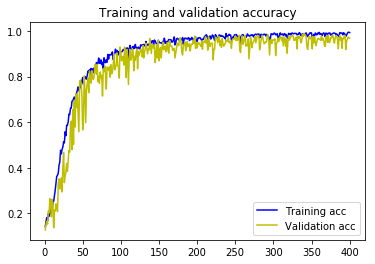

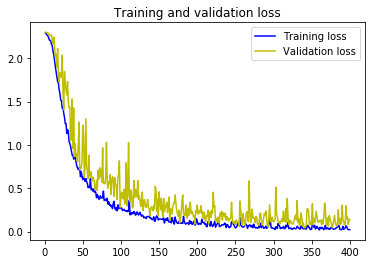

In [29]:
plot_history(history)

In [34]:
save_model(model, history, 'vanilla reduced')

In [52]:
!onepanel

/bin/sh: 1: onepanel: not found


In [ ]:
def vanilla_cnn_keras(input_shape: tuple=(128, 128, 3), classes: int=10, optimizer: (str, Optimizer)='adam'):
    """Implement vanilla ConvNet model.
    
    Args:
        input_shape: tuple, image shape, channel last, default (128, 128, 3)
        classes: int, image classes, default 10
        optimizer: str or Optimizer, optimizer to compile model, default adam
    Returns:
        model: Model, vanilla cnn model
    """
    model = Sequential([
        layers.Conv2D(16, 3, activation='relu',
                      input_shape=input_shape),
        layers.Conv2D(16, 3, activation='relu'),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(classes, activation='softmax')
    ])
   
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model